In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mne
import pickle 
import yaml
from tabulate import tabulate
import pandas as pd

from gait_modulation.utils.file_reader import MatFileReader
from gait_modulation.utils.data_processor import DataProcessor
from gait_modulation.viz import Visualise
from gait_modulation.utils.feature_extractor import FeatureExtractor
from gait_modulation.utils.utils import load_config

# Loading the data

In [2]:
config = load_config('gait_modulation/configs/data_preprocessing.yaml')

In [3]:
# Handle multiple patients with nested directories.
root_directory = config['data']['root_directory']
subject_id = config['data']['subject_id']
# subject_id = ['PW_HK59']

mat_reader = MatFileReader(root_directory, subject_id)  # adjust the number of workers for parallelism later.

# Read all data from nested folders of multiple patients and sessions
data = mat_reader.read_data(max_workers=10)
n_subjects = len(data)

print(f"Number of subjects: {n_subjects}")

Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulation_Prediction_DATA/PW_HZ58/15-09-23/MAT/walking_sync_updated_4.mat
Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulation_Prediction_DATA/PW_HZ58/15-09-23/MAT/walking_sync_updated_6.mat
Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulation_Prediction_DATA/PW_HZ58/15-09-23/MAT/walking_sync_updated_3.mat
Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulation_Prediction_DATA/PW_US68/20-12-22/MAT/walking_sync_updated_2.mat
Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulation_Prediction_DATA/PW_US68/20-12-22/MAT/walking_sync_updated_1.mat
Loading: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Rita/Gait_Modulat

In [4]:
for patient, sessions in data.items():
    print(f"Patient: {patient}, Sessions: {list(sessions.keys())}")

Patient: PW_US68, Sessions: ['walking_sync_updated_3', 'walking_sync_updated_1', 'walking_sync_updated_2']
Patient: PW_HZ58, Sessions: ['walking_sync_updated_6', 'walking_sync_updated_3', 'walking_sync_updated_4']
Patient: PW_FH57, Sessions: ['walking_sync_updated_1', 'walking_sync_updated_2', 'walking_sync_updated_3', 'walking_sync_updated_4']
Patient: PW_HK59, Sessions: ['walking_sync_updated_3', 'walking_sync_updated_1', 'walking_sync_updated_2']
Patient: PW_EM59, Sessions: ['walking_sync_updated_3']
Patient: PW_SN66, Sessions: ['walking_sync_updated_2', 'walking_sync_updated_1']
Patient: PW_SN61, Sessions: ['walking_sync_updated_1', 'walking_sync_updated_2', 'walking_sync_updated_3', 'walking_sync_updated_4']


In [5]:
valid_data_types = ['data_acc', 'data_EEG', 'data_EMG', 'data_giro', 'data_LFP']
data_type = 'data_LFP'

try:
    # Pick any subject/session to extract common meta data e.g. the first one
    first_subject = list(data.keys())[0]
    first_session = list(data[first_subject].keys())[0]
    first_data = data[first_subject][first_session]
    if data_type not in valid_data_types:
        raise ValueError("Invalid data type specified.")
except Exception as e:
    raise ValueError(f"Error processing data: {e}")

data_names = ['data_EEG', 'data_EMG', 'data_LFP', 'data_acc', 'data_giro', 'events_KIN', 'events_STEPS', 'filePath_2', 'hdr_EEG', 'hdr_EMG', 'hdr_IMU', 'hdr_LFP', 'pt', 'session']
if not np.all([dt in data_names for dt in first_data.keys()]):
    raise ValueError(f"Invalid data type found in the data.")

# Extract LFP meta data for subject/session
# lfp_metadata = DataProcessor.np_to_dict(first_data['hdr_LFP'])

lfp_metadata = first_data['hdr_LFP']
lfp_sfreq = lfp_metadata['Fs']
lfp_metadata

{'Fs': 250,
 'labels': array(['ZERO_THREE_LEFT', 'ONE_THREE_LEFT', 'ZERO_TWO_LEFT',
        'ZERO_THREE_RIGHT', 'ONE_THREE_RIGHT', 'ZERO_TWO_RIGHT'],
       dtype=object),
 'NumberOfChannels': 6,
 'chanunit': array(['µV', 'µV', 'µV', 'µV', 'µV', 'µV'], dtype='<U2'),
 'chantype': array(['LFP', 'LFP', 'LFP', 'LFP', 'LFP', 'LFP'], dtype='<U3')}

In [6]:
# Process the LFP data
# epochs, events, lfp_raw_list, all_lfp_data = DataProcessor.process_lfp_data()(
#     data, n_sessions, lfp_sfreq, event_of_interest, mod_start_event_id,
#     normal_walking_event_id, gap_sample_length, epoch_sample_length,
#     epoch_tmin, epoch_tmax, epoch_duration, event_dict, info, reject_criteria, config, verbose=False)

In [7]:
fig_save_path ='results/figures/processed_data'
os.makedirs(fig_save_path, exist_ok=True)

fix_chs_names = [
    'ZERO_THREE_LEFT',
    'ONE_THREE_LEFT',
    'ZERO_TWO_LEFT',
    'ZERO_THREE_RIGHT',
    'ONE_THREE_RIGHT',
    'ZERO_TWO_RIGHT']

new_events_order = [
    'trial_start',
    'VA_start_walking',
    'mod_start',
    'VA_cross',
    'min_vel',
    'min_dist',
    'mod_end',
    'trial_stop']

key_map = {"label": "labels",
           "time": "times"}
        
DataProcessor.clean_data(data, 'data_LFP', key_map, new_events_order, lfp_sfreq, fix_chs_names)

subjects_lfp_data_dict, subjects_event_idx_dict = DataProcessor.process_trials_and_events(data, 'data_LFP', lfp_sfreq, config, verbose=True)

Patient ID: PW_US68
walking_sync_updated_3: 6 channels found
--------------------------------------------------
walking_sync_updated_1: 6 channels found
--------------------------------------------------
walking_sync_updated_2: 6 channels found
--------------------------------------------------
Patient ID: PW_HZ58
walking_sync_updated_6: 6 channels found
--------------------------------------------------
walking_sync_updated_3: 6 channels found
--------------------------------------------------
walking_sync_updated_4: 6 channels found
--------------------------------------------------
Patient ID: PW_FH57
walking_sync_updated_1: 6 channels found
--------------------------------------------------
walking_sync_updated_2: 6 channels found
--------------------------------------------------
walking_sync_updated_3: 6 channels found
--------------------------------------------------
walking_sync_updated_4: 6 channels found
--------------------------------------------------
Patient ID: PW_HK59


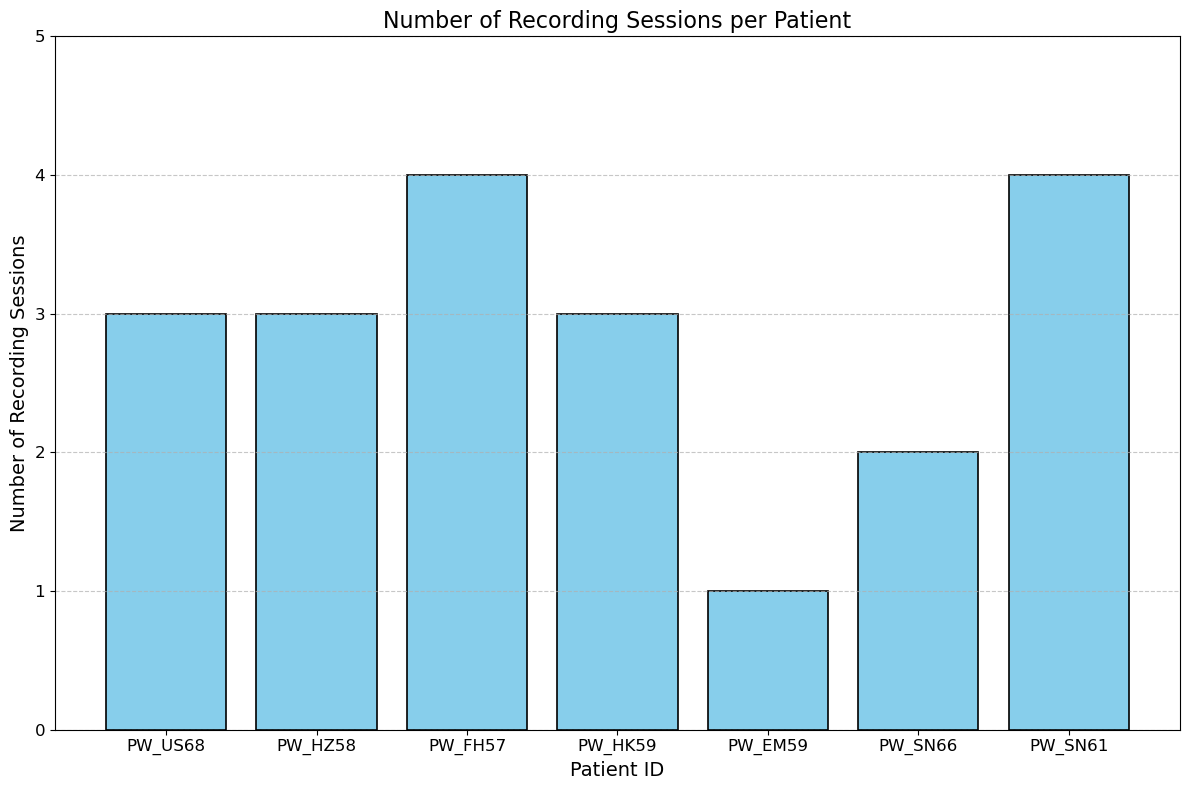

patient_id  n_essions
0    PW_US68          3
1    PW_HZ58          3
2    PW_FH57          4
3    PW_HK59          3
4    PW_EM59          1
5    PW_SN66          2
6    PW_SN61          4

In [8]:
# Count the number of recording sessions per patient
df_session_counts = pd.DataFrame(
    [(patient, len(sessions)) for patient, sessions in data.items()],
    columns=["patient_id", "n_essions"]
)
# Call the function to plot the session counts
Visualise.plot_session_counts(df_session_counts, fig_save_path, fig_name='session_counts')

df_session_counts

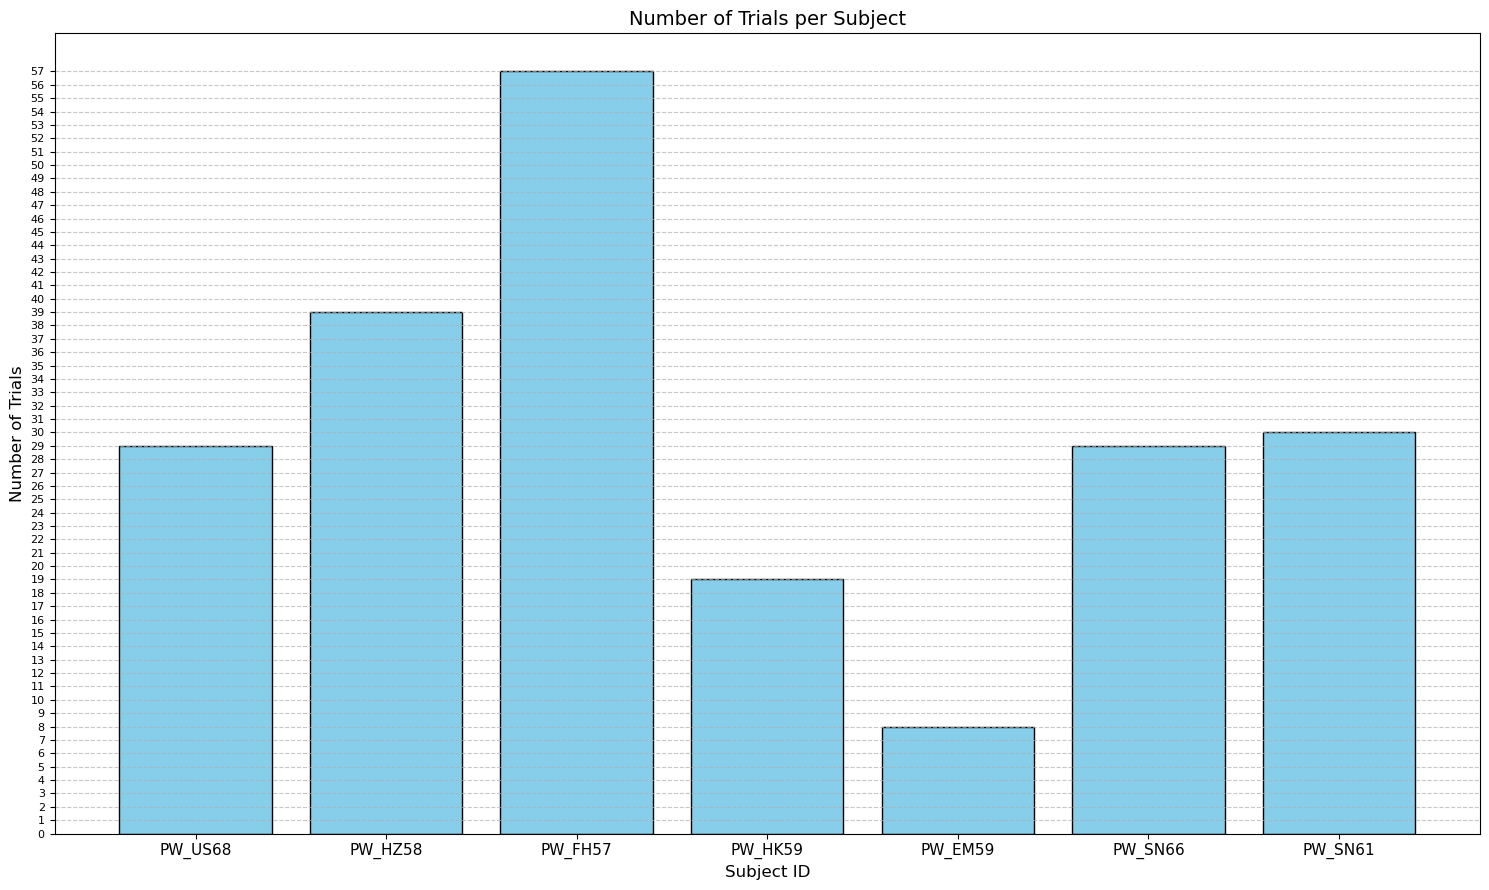

subject_id  n_trials
0    PW_US68        29
1    PW_HZ58        39
2    PW_FH57        57
3    PW_HK59        19
4    PW_EM59         8
5    PW_SN66        29
6    PW_SN61        30

In [9]:
n_subjects = len(subjects_event_idx_dict)
n_trials_list = []
subjects_list = []

table_data = []
for subject_name, event_data in subjects_event_idx_dict.items():
    n_trials = event_data.shape[0]
    n_trials_list.append(n_trials)
    subjects_list.append(subject_name)
    table_data.append([subject_name, n_trials])
df_trial_counts = pd.DataFrame(table_data, columns=["subject_id", "n_trials"])

Visualise.plot_trial_counts(df_trial_counts, fig_save_path, fig_name='trials_per_subject')

df_trial_counts

In [10]:
min_trial_length = min(
    trial.shape[1]
    for subject_trials in subjects_lfp_data_dict.values()
    for trial in subject_trials
)

max_trial_length = max(
    trial.shape[1]
    for subject_trials in subjects_lfp_data_dict.values()
    for trial in subject_trials
)
print(f"Minimum trial length: {min_trial_length} ({min_trial_length/lfp_sfreq} seconds)")
print(f"Maximum trial length: {max_trial_length } ({max_trial_length/lfp_sfreq} seconds)")

print(f"\n{'-' * 25}\n| Number of subjects: {len(subjects_lfp_data_dict)} |\n{'-' * 25}")
for i, subject_name in enumerate(subjects_lfp_data_dict):
    print(f"\n{i+1}. Subject {subject_name}: Number of trials: {len(subjects_lfp_data_dict[subject_name])}, each with shape (n_channels, n_samples):")
    print("=" * 82)
    for trial_idx in range(len(subjects_lfp_data_dict[subject_name])):
        print(f"{trial_idx+1}. Trial: {subjects_lfp_data_dict[subject_name][trial_idx].shape}")

Minimum trial length: 1050 (4.2 seconds)
Maximum trial length: 7550 (30.2 seconds)

-------------------------
| Number of subjects: 7 |
-------------------------

1. Subject PW_US68: Number of trials: 29, each with shape (n_channels, n_samples):
1. Trial: (6, 1355)
2. Trial: (6, 1630)
3. Trial: (6, 1210)
4. Trial: (6, 1270)
5. Trial: (6, 1225)
6. Trial: (6, 1470)
7. Trial: (6, 1585)
8. Trial: (6, 1800)
9. Trial: (6, 1715)
10. Trial: (6, 1545)
11. Trial: (6, 1375)
12. Trial: (6, 1355)
13. Trial: (6, 1220)
14. Trial: (6, 1625)
15. Trial: (6, 1595)
16. Trial: (6, 1475)
17. Trial: (6, 1690)
18. Trial: (6, 1335)
19. Trial: (6, 1330)
20. Trial: (6, 1410)
21. Trial: (6, 1650)
22. Trial: (6, 1755)
23. Trial: (6, 1670)
24. Trial: (6, 1730)
25. Trial: (6, 1510)
26. Trial: (6, 1270)
27. Trial: (6, 1495)
28. Trial: (6, 1840)
29. Trial: (6, 1475)

2. Subject PW_HZ58: Number of trials: 39, each with shape (n_channels, n_samples):
1. Trial: (6, 1765)
2. Trial: (6, 1720)
3. Trial: (6, 1790)
4. Trial: 

/Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/gait_modulation/gait_modulation/viz.py:130: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


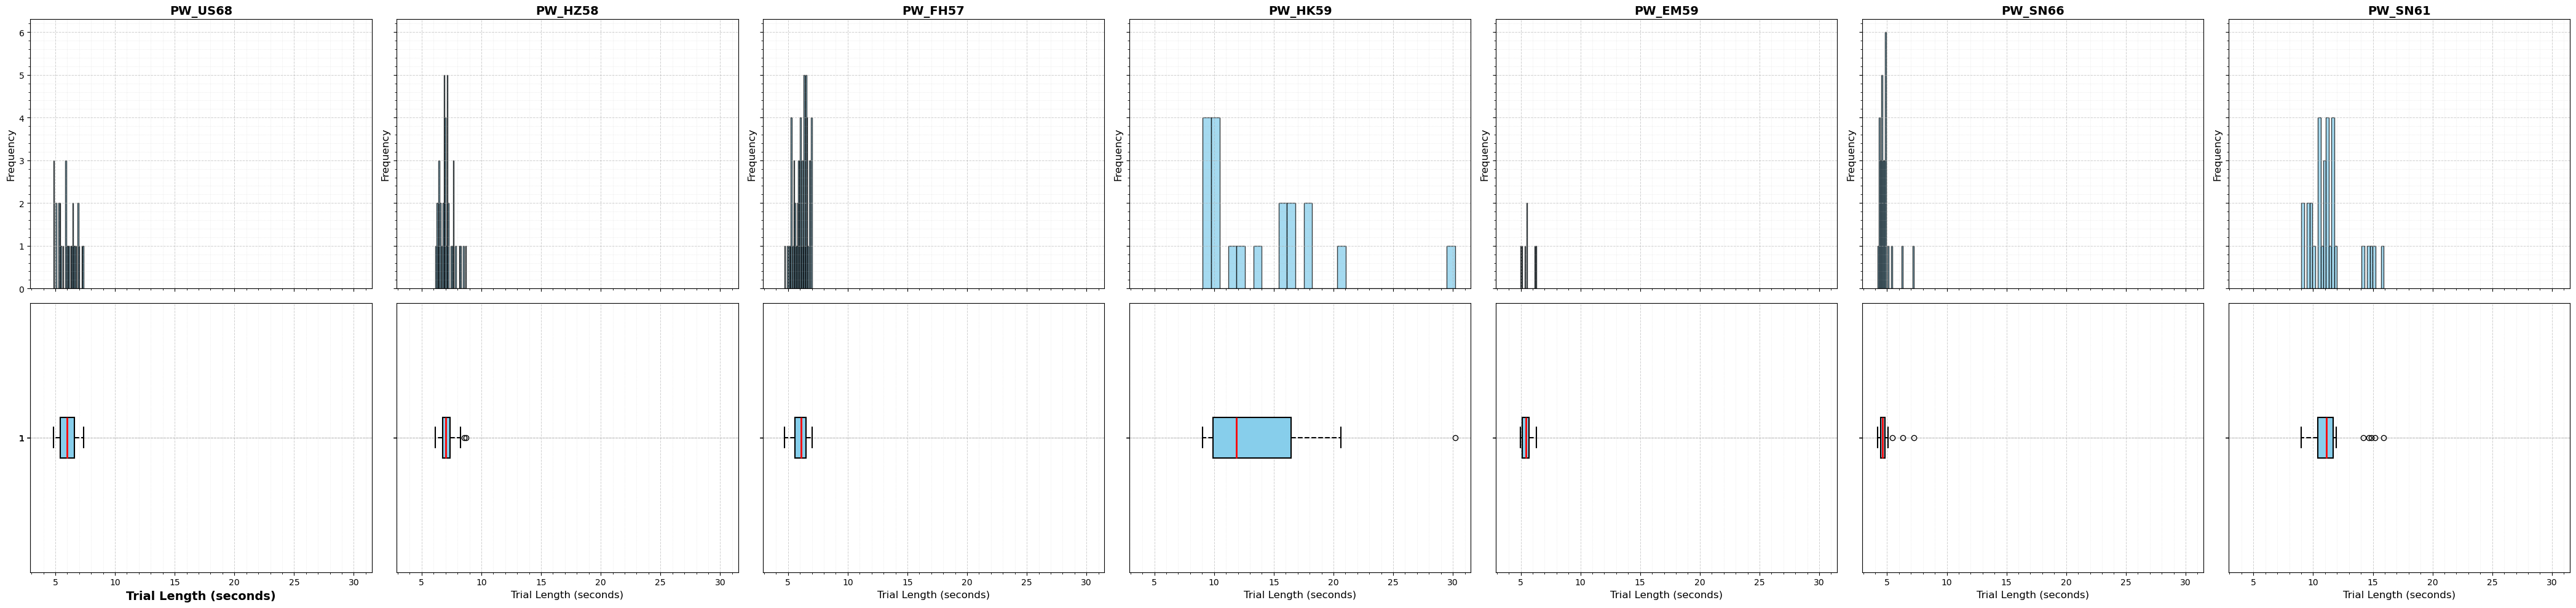

In [11]:
Visualise.plot_trial_lengths_per_subject_distr(subjects_lfp_data_dict, lfp_sfreq, fig_save_path, fig_name='trial_lengths_per_subject_distr')

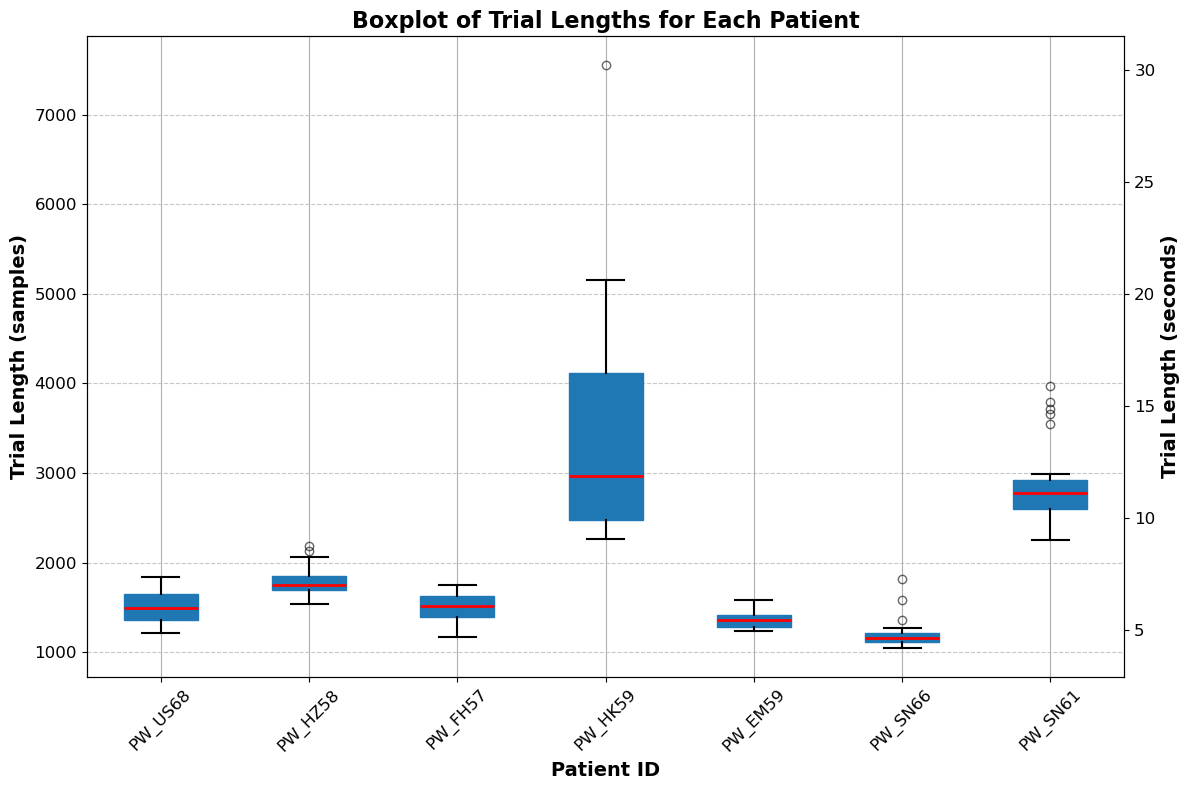

In [12]:
Visualise.plot_trial_lengths_per_subject_boxplot(subjects_lfp_data_dict, lfp_sfreq, fig_save_path, fig_name='trial_lengths_per_subject_boxplot')

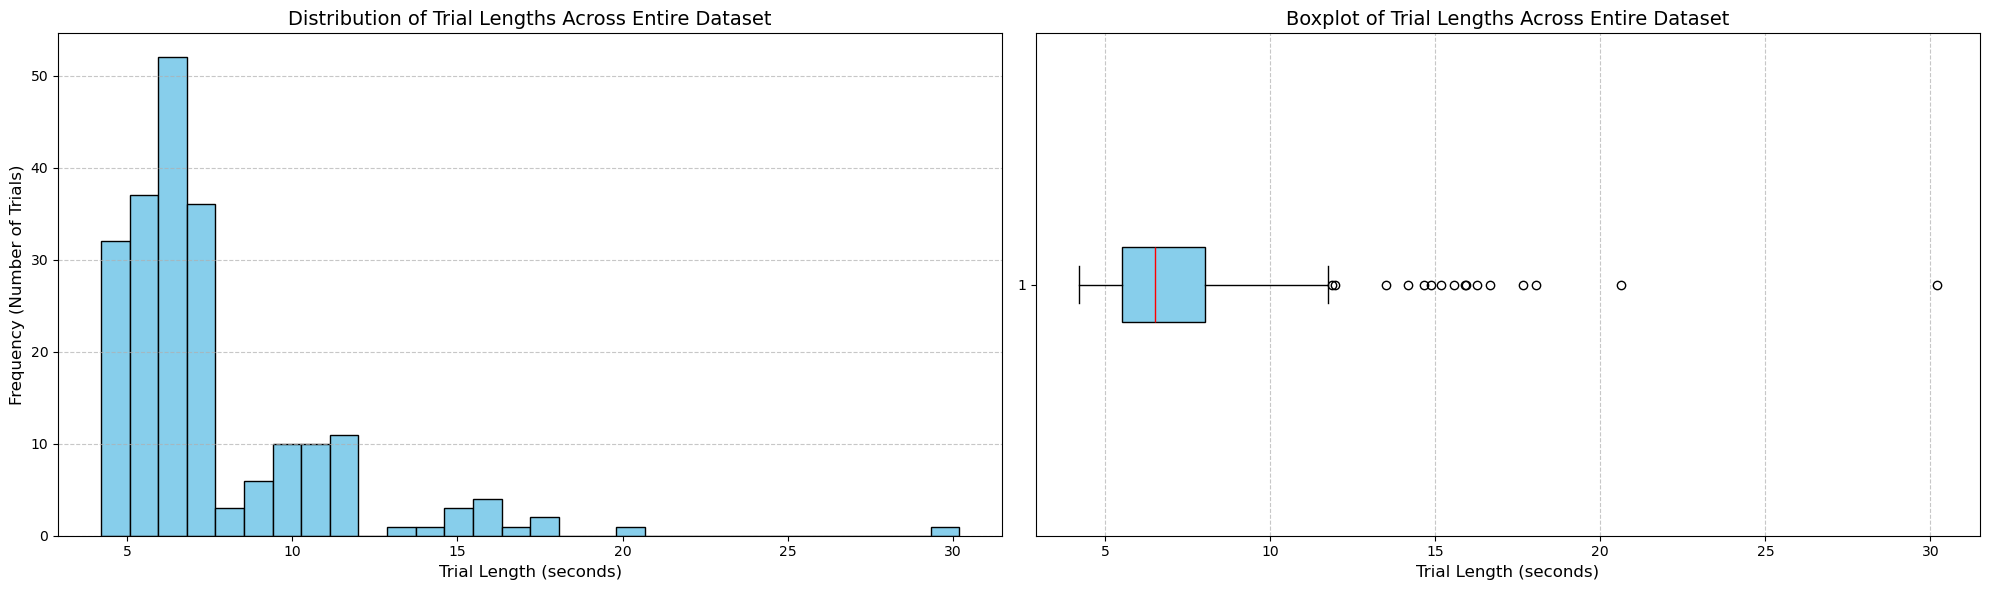

In [13]:
Visualise.plot_all_trial_lengths(subjects_lfp_data_dict, lfp_sfreq, fig_save_path, fig_name='all_trial_length_combined')

In [15]:
Visualise().plot_all_patients_trials(
    data=subjects_lfp_data_dict,
    sfreq=lfp_sfreq,
    save_path=fig_save_path,
    fig_name='lfp_data_all_patients_trials',
    sharex=True,
    sharey=True,
)

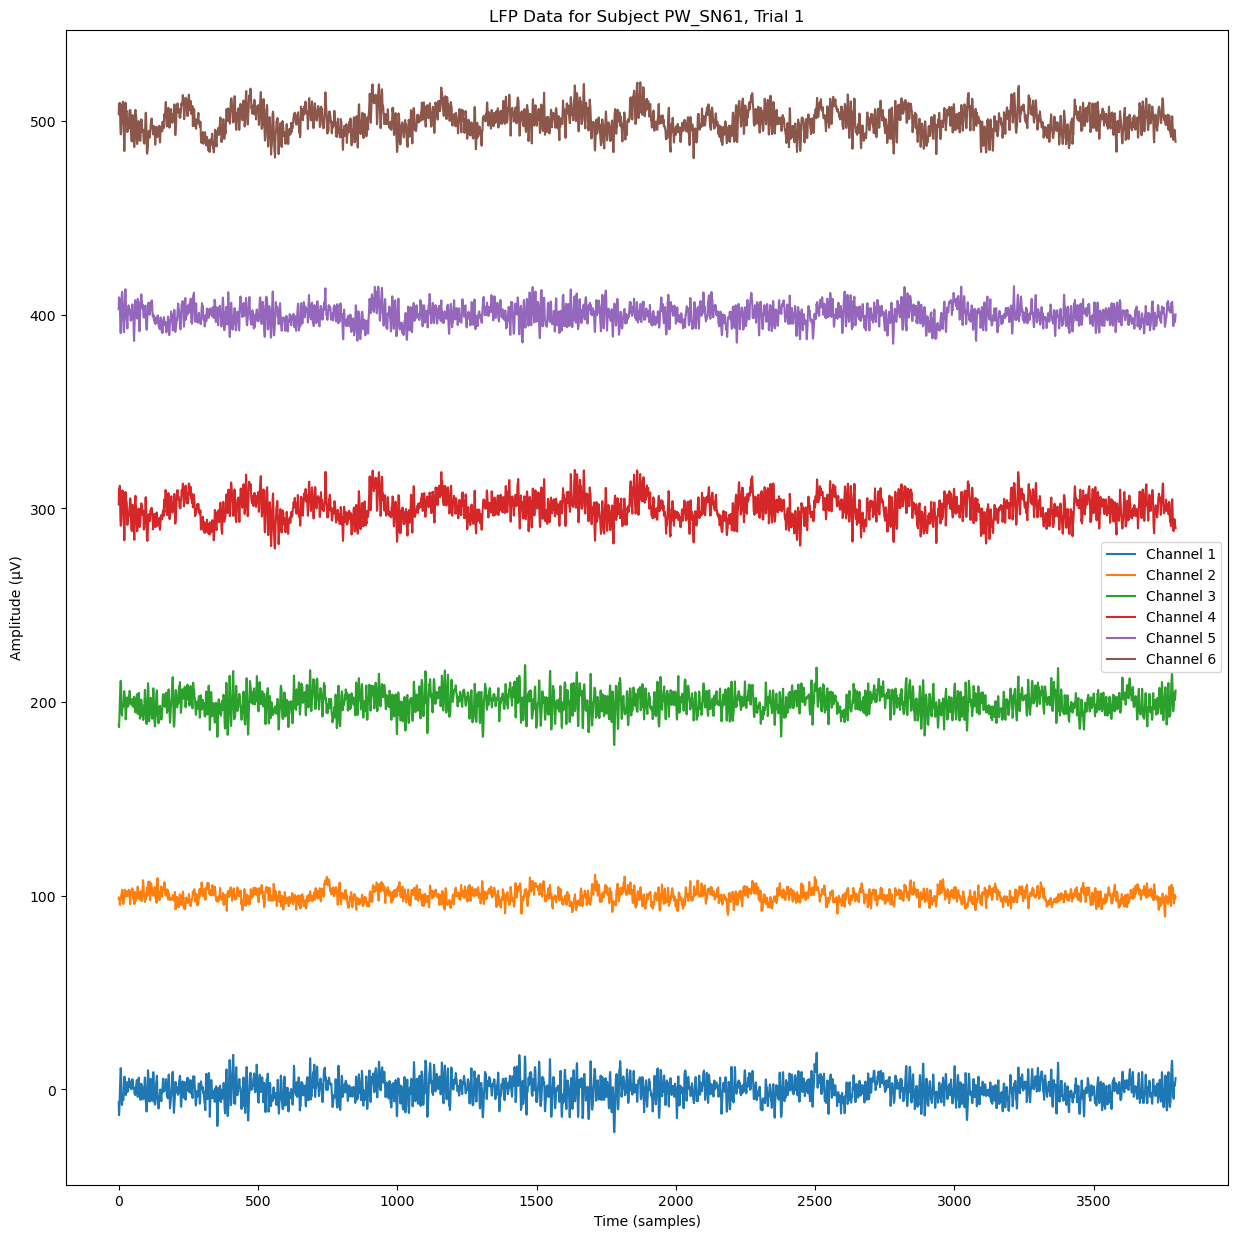

In [21]:
subject = 'PW_SN61'  # specify the subject
trial_index = 0  # specify the trial index

# Extract the data for the specified subject and trial
trial_data = subjects_lfp_data_dict[subject][trial_index]

# Plot the data
plt.figure(figsize=(15, 15))
for channel in range(trial_data.shape[0]):
    plt.plot(trial_data[channel, :] + channel * 100, label=f'Channel {channel + 1}')

plt.title(f'LFP Data for Subject {subject}, Trial {trial_index + 1}')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.show()

---
# Segmentation

In [ ]:
#  Notes:
#     - The function pads or truncates the LFP data based on the configuration settings.

# Ensure all trials have a common length (across other trials & subjects) by either truncating or padding them, and save the result as a 3D numpy array (n_trials, n_channels, n_times)

max_trial_length = max(
    trial.shape[1]
    for subject_trials in subjects_lfp_data_dict.values()
    for trial in subject_trials
)

subjects_data = []
for subject_trials in subjects_lfp_data_dict.values():
    # for trial in subject_trials:
    subjects_data.append(DataProcessor.pad_or_truncate(subject_trials, config, max_trial_length))
    
for s in subjects_data:
    print(s.shape)
    
# Stack all subjects' data to form a single array of trials
all_trials_data = np.vstack(subjects_data)
print(f"All trials data shape: {all_trials_data.shape}")

In [14]:
# Load LFP parameters
lfp_ch_names = DataProcessor.rename_lfp_channels(lfp_metadata['labels'])
lfp_n_channels = lfp_metadata['NumberOfChannels']

info = mne.create_info(ch_names=lfp_ch_names, sfreq=lfp_sfreq, ch_types='dbs', verbose=40)

# Define normal walking events and mod_start
event_of_interest = config['events']['event_of_interest']
other_events = config['events']['other_events']

mod_start_event_id = config['events']['mod_start_event_id']
normal_walking_event_id = config['events']['normal_walking_event_id']

# Define the event dictionary
event_dict = {
    event_of_interest: mod_start_event_id,
    other_events: normal_walking_event_id
}

# Segmentation parameters
epoch_tmin = config['segmentation']['epoch_tmin']
epoch_tmax = config['segmentation']['epoch_tmax']
epoch_duration = epoch_tmax - epoch_tmin

epoch_sample_length = int(epoch_duration * lfp_sfreq)
gap_duration = config['segmentation']['gap_duration']
gap_sample_length = int(gap_duration * lfp_sfreq)

reject_criteria = {'dbs': float(config['reject_criteria']['dbs_threshold'])}

In [15]:
Visualise.plot_raw_data_with_annotations(
    lfp_raw_list, scaling=5e1, folder_path='images/raw')

NameError: name 'lfp_raw_list' is not defined

In [ ]:
# save all lfp data
with open('processed/all_lfp_data.pkl', 'wb') as f:
    pickle.dump(all_lfp_data, f)
    
with open('processed/lfp_raw_list.pkl', 'wb') as f:
    pickle.dump(lfp_raw_list, f)
    
# save epoched data
epochs.save(f"processed/lfp_{epoch_tmin}tmin_{gap_duration}gap-epo.fif", overwrite=True)
    

In [ ]:
Visualise.plot_event_occurrence(events=events, 
                                epoch_sample_length=epoch_sample_length, 
                                lfp_sfreq=lfp_sfreq, 
                                event_dict=event_dict,
                                # gait_modulation_event_id=mod_start_event_id, 
                                # normal_walking_event_id=normal_walking_event_id, 
                                n_sessions=n_sessions,
                                show_fig=False, 
                                save_fig=True, 
                                file_name=f'images/event_classes.png')


Visualise.plot_event_occurrence(events=epochs.events, 
                                epoch_sample_length=epoch_sample_length, 
                                lfp_sfreq=lfp_sfreq, 
                                event_dict=event_dict,
                                # gait_modulation_event_id=mod_start_event_id, 
                                # normal_walking_event_id=normal_walking_event_id, 
                                n_sessions=n_sessions,
                                show_fig=False, 
                                save_fig=True, 
                                file_name=f'images/epochs.event_classes.png')

In [ ]:
Visualise.plot_event_class_histogram(events=events,
                                    event_dict=epochs.event_id,
                                    n_sessions=n_sessions,
                                    show_fig=False, 
                                    save_fig=True,
                                    file_name=f'images/event_class_histogram.png')

Visualise.plot_event_class_histogram(events=epochs.events,
                                    event_dict=epochs.event_id,
                                    n_sessions=n_sessions,
                                    show_fig=False, 
                                    save_fig=True,
                                    file_name=f'images/epochs.event_class_histogram.png')